## Try to get all hydrogens around metal atoms about a conventional cell

In [1]:
from pymatgen.core.structure import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from collections import defaultdict

## Count the amount of a specie in a cell

In [2]:
pmg_struct = Structure.from_file("./CaH6.cif")
pmg_struct.composition.to_data_dict
# {
#   'reduced_cell_composition': Comp: Li2 Mg1 H16,
#   'unit_cell_composition': defaultdict(float,
#              {'Li': 16.0, 'Mg': 8.0, 'H': 128.0}),
#   'reduced_cell_formula': 'Li2MgH16',
#   'elements': ['Li', 'Mg', 'H'],
#   'nelements': 3
# }
pmg_struct.composition.num_atoms            # get amounts of all atoms
pmg_struct.composition.alphabetical_formula # 'H128 Li16 Mg8'
pmg_struct.composition.anonymized_formula   # 'AB2C16'
pmg_struct.composition.iupac_formula        # 'Li16 Mg8 H128'
pmg_struct.composition.chemical_system      # 'H-Li-Mg'
pmg_struct.composition.elements             # [Element Li, Element Mg, Element H]
pmg_struct.composition.special_formulas     #{
                                            #     'LiO': 'Li2O2',
                                            #     'NaO': 'Na2O2',
                                            #     'KO': 'K2O2',
                                            #     'HO': 'H2O2',
                                            #     'CsO': 'Cs2O2',
                                            #     'RbO': 'Rb2O2',
                                            #     'O': 'O2',
                                            #     'N': 'N2',
                                            #     'F': 'F2',
                                            #     'Cl': 'Cl2',
                                            #     'H': 'H2'
                                            # }
pmg_struct.composition.get_el_amt_dict()                    # defaultdict(float, {'Li': 16.0, 'Mg': 8.0, 'H': 128.0})
pmg_struct.composition.get_integer_formula_and_factor()     # ('Li2MgH16', 8.0)
pmg_struct.composition.get_reduced_composition_and_factor() # (Comp: Li2 Mg1 H16, 8)


e:\conda\envs\cage\lib\site-packages\pymatgen\io\cif.py:1229: UserWarning: Issues encountered while parsing CIF: Skipping relative stoichiometry check because CIF does not contain formula keys.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))


(Composition('Ca1 H6'), 2)

## **一个小工具** 输入一个结构，输出其约化化学式，空间群对称性，文件名

In [27]:
import sys
from pathlib import Path

from pymatgen.core.structure import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer


struct = Structure.from_file("../test/POSCAR_YH9")
name = struct.composition.get_integer_formula_and_factor()[0]
spg = SpacegroupAnalyzer(struct)
num = spg.get_space_group_number()
spg_symbol = spg.get_space_group_symbol()
print(f"{num}-{spg_symbol}-{name}")
struct.lattice.matrix

194-P6_3/mmc-YH9


array([[ 3.38071002e+00,  6.97590750e-09,  0.00000000e+00],
       [-1.69035500e+00,  2.92778074e+00, -0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  5.29484392e+00]])

# 计算选择矩阵的类型

In [40]:
import numpy as np
from pymatgen.core.structure import Molecule
from pymatgen.symmetry.analyzer import PointGroupAnalyzer

def get_operation_type(Lattice, rotation):
    """
    Calculates the rotation axis and angle of the symmetry and if it 
    preserves handedness or not. 计算对称的旋转轴和角度，以及它是否保留手性。

    Returns
    -------
    tuple
        The first element is an array describing the rotation axis. The 
        second element describes the rotation angle. The third element is a 
        boolean, `True` if the symmetry preserves handedness 
        (determinant -1).
    """
    rotxyz = Lattice.T.dot(rotation).dot(np.linalg.inv(Lattice).T) #这里是为什么？？？？
    print ("1rotation in real space:\n",rotxyz)
    E, V = np.linalg.eig(rotxyz)
    if not np.isclose(abs(E), 1).all():
        raise RuntimeError(
            "some eigenvalues of the rotation are not unitary")
            # 旋转的一些特征值是不酉的, 即, S·S-1 != E
    if E.prod() < 0:
        inversion = True
        E *= -1
    else:
        inversion = False
    idx = np.argsort(E.real)
    E = E[idx]
    V = V[:, idx]
    axis = V[:, 2].real
    if np.isclose(E[:2], 1).all():
        angle = 0
    elif np.isclose(E[:2], -1).all():
        angle = np.pi
    else:
        angle = np.angle(E[0])
        v = V[:, 0]
        s = np.real(np.linalg.det([v, v.conj(), axis]) / 1.j)
        if np.isclose(s, -1):
            angle = 2 * np.pi - angle
        elif not np.isclose(s, 1):
            raise RuntimeError("the sign of rotation should be +-1")
    return (axis, angle, inversion)

r_zhi = np.array([
    [-np.sin(np.pi/6), -np.cos(np.pi/6), 0],
    [ np.cos(np.pi/6), -np.sin(np.pi/6), 0],
    [0, 0, 1],
])
r_liu = np.array([
    [ 0,  1,  0],
    [-1,  1,  0],
    [ 0,  0,  1],
])

axis, angle, inversion = get_operation_type(struct.lattice.matrix, r_liu)
axis, np.degrees(angle), inversion 

1rotation in real space:
 [[ 0.5         0.86602541  0.        ]
 [-0.8660254   0.5         0.        ]
 [ 0.          0.          1.        ]]


(array([0., 0., 1.]), 299.99999999999994, False)

In [29]:
r_zhi = np.array([
    [-np.sin(np.pi/6), -np.cos(np.pi/6)],
    [ np.cos(np.pi/6), -np.sin(np.pi/6)]
])
r_liu = np.array([
    [0, -1],
    [1, -1]
])

s_1 = np.linalg.inv([
    [1, -np.sin(np.pi/6)],
    [0,  np.cos(np.pi/6)]
])
s = np.array(([
    [1, -np.sin(np.pi/6)],
    [0,  np.cos(np.pi/6)]
]))

# print(np.dot(np.dot(s, r_zhi), s_1))
print(np.dot(np.dot(s_1, r_zhi), s))

print(np.dot(np.dot(s, r_liu), s_1))
# print(np.dot(np.dot(s_1, r_liu), s))

[[-5.55111512e-17 -1.00000000e+00]
 [ 1.00000000e+00 -1.00000000e+00]]
[[-0.5       -0.8660254]
 [ 0.8660254 -0.5      ]]


In [5]:
from numpy import array
from typing import List
from pymatgen.symmetry.analyzer import SymmOp
import numpy as np

def is_in_matrix(m:array,ms:List[array]):
    # 判断矩阵m是否在矩阵组成的列表ms中
    flag = True
    for _ in ms:
        if np.allclose(m, _):
            flag = True
            break
    else:
        flag = False
    return flag

def kill_duplicated_element(ms:array):
    # 在一组 3*3的矩阵中，找到重复的并删除
    new_ms = []
    for m in ms:
        if not new_ms:
            new_ms.append(m)
        else:
            if not is_in_matrix(m=m, ms=new_ms):
                new_ms.append(m)
    return new_ms

def is_equal_for_cless(cl1:List[array], cl2:List[array]):
    # 判断两个类是否相同
    flag = True
    for m1 in cl1:
        if is_in_matrix(m1, cl2):
            flag = True
            break
    else:
        flag = False
    return flag

def is_in_clesses(cl1:List[array], clesses:List[List[array]]):
    flag = True
    for cl2 in clesses:
        if is_equal_for_cless(cl1, cl2):
            flag = True
            break
    else:
        flag = False
    return flag

def kill_duplicated_clesses(clesses:List[List[array]]):
    new_clesses = []
    for cl in clesses: # cl此时是一个类，里面有很多个3*3的矩阵
        if not new_clesses:
            new_clesses.append(cl)
        else:
            if not is_in_clesses(cl1=cl, clesses=new_clesses):
                new_clesses.append(cl)
    return new_clesses


def find_cless_ops(cless:List[array]):
    tmplist = []
    for rot in cless:
        for op in pgops:
            if np.allclose(op.rotation_matrix, rot):
                tmplist.append(op)
                break
    return tmplist

def get_rot_name(rot):
    # print(rot)
    typename = ''
    det = np.linalg.det(rot) 
    if det > 0: # det(rot)=1: rotation; 
        trc = np.trace(rot)
        theta = np.degrees(np.arccos((trc-1)/2))
        # print(trc); print(theta)
        if np.allclose(theta, 0.0):
            typename = "identity"
        else:
            typename = "rotation"+str(int(theta))
    else: # det(rot)=-1: rotoinversion
        trc = -np.trace(rot)
        theta = np.degrees(np.arccos((trc-1)/2))
        # print(trc); print(theta)
        if np.allclose(theta, 0.0):
            typename = "inversion"
        else:
            typename = "rotoinversion"+str(int(theta))

    return typename

def get_cless_name(cless:List[SymmOp]):
    namelist = []
    for op in cless:
        name = get_rot_name(op.rotation_matrix)
        namelist.append(name)
    
    if len(set(namelist)) == 1:
        return namelist[0]+ "_" + str(len(namelist))
    else:
        raise ValueError("Error: namelist={}".format(namelist))

def classify_ops(pgops:List[SymmOp]):
    clesseslist: List[array] = []
    for idx, op in enumerate(pgops):
        # print(op.as_xyz_str())
        bm = [np.dot(np.dot(np.linalg.inv(x.rotation_matrix), op.rotation_matrix), x.rotation_matrix) for x in pgops]
        # print(bm)
        cless = kill_duplicated_element(bm)
        # print(cless)
        # for m in cless:
        #     print(detailed_info(m))
        # break
        clesseslist.append(cless)

    clesseslist = kill_duplicated_clesses(clesseslist)

    clessesdict = defaultdict(list)
    for idx, cless in enumerate(clesseslist):
        tmp:List[SymmOp] = find_cless_ops(cless)
        clessname:str = get_cless_name(tmp)
        clessesdict[f'{clessname}'] = tmp

    clessesdict:dict[List[SymmOp]] = dict(clessesdict)
    return clessesdict

print(pgops)

new_pgops:dict[List[SymmOp]] = classify_ops(pgops)
print(new_pgops.keys())

[SymmOp(affine_matrix=array([[ 1., -0., -0.,  0.],
       [-0.,  1., -0.,  0.],
       [-0., -0., -1.,  0.],
       [ 0.,  0.,  0.,  1.]])), SymmOp(affine_matrix=array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]]))]
dict_keys(['rotoinversion180_1', 'identity_1'])


In [6]:
def generate_mapping_matrix(mapping):
    """
    通过给定的映射关系生成矩阵 A

    Args:
        mapping: 一个字典，表示映射关系，键为第一列的元素，值为第二列的元素

    Returns:
        矩阵 A
    """
    # 确定矩阵 A 的大小
    size = len(mapping)
    A = [[0] * size for _ in range(size)]

    # 遍历映射关系，填充矩阵 A
    for idx, key in enumerate(mapping):
        value = mapping[key]
        A[idx][value] = 1
    # print(mapping)
    return A


def get_atoms_mapping(op:SymmOp, struct:Structure):

    from pymatgen.core.sites import PeriodicSite
    
    mapping = {}
    for idx1, site1 in enumerate(struct):
        newcoords = op.operate(site1.frac_coords)
        newsite = PeriodicSite(species=site1.species, coords=newcoords, to_unit_cell=True, lattice=struct.lattice)
        for idx2, site2 in enumerate(struct):
            if np.allclose(newsite.coords, site2.coords, rtol=1e-4):  # pymatgen 源代码检查了元素是否相等，坐标是否相等，性质是否相等 self.species == other.species and np.allclose(self.coords, other.coords, atol=Site.position_atol) and self.properties == other.properties
                # print("{} {}-> {} {}".format(idx1, site1.frac_coords, idx2, newsite.frac_coords))
                # print("{} {}-> {} {}".format(idx1, site1, idx2, newsite))
                mapping[idx1] = idx2
    return mapping

# for name in ['identity_1', 'rotation180_3', 'rotation180_6', 'rotation120_8', 'rotation90_6', 'inversion_1', 'rotoinversion180_3', 'rotoinversion180_6', 'rotoinversion120_8', 'rotoinversion90_6']:
#     print(get_atoms_mapping(new_pgops[name][0], struct=struct))

def get_conjugate_character(ops:List[SymmOp], struct):

    trcs    = []
    for op in ops:
        mapping = get_atoms_mapping(op, struct)
        A = generate_mapping_matrix(mapping)
        trc = np.trace(A)
        trcs.append(trc)
    if len(set(trcs)) == 1:
        return trc

# for name in ['identity_1', 'rotation180_3', 'rotation180_6', 'rotation120_8', 'rotation90_6', 'inversion_1', 'rotoinversion180_3', 'rotoinversion180_6', 'rotoinversion120_8', 'rotoinversion90_6']:
#     print(get_conjugate_character(new_pgops[name], struct=struct))

def get_atomic_character(new_pgops, struct):
    
    atomic_charater = {}
    for name, ops in new_pgops.items():
        print("---- check cless {} ----".format(name))
        trc = get_conjugate_character(ops, struct)
        atomic_charater[name] = trc
    return atomic_charater

conjugate_charater = get_atomic_character(new_pgops, struct)
# for name in ['identity_1', 'rotation180_3', 'rotation180_6', 'rotation120_8', 'rotation90_6', 'inversion_1', 'rotoinversion180_3', 'rotoinversion180_6', 'rotoinversion120_8', 'rotoinversion90_6']:
# names = ['identity_1','rotation90_6', 'rotation180_3', 'rotation120_8', 'rotation180_6',  'inversion_1', 'rotoinversion90_6', 'rotoinversion180_3',  'rotoinversion120_8', 'rotoinversion180_6', ]

# mult  = [int(name.split('_')[-1]) for name in ['identity_1','rotation90_6', 'rotation180_3', 'rotation120_8', 'rotation180_6',  'inversion_1', 'rotoinversion90_6', 'rotoinversion180_3',  'rotoinversion120_8', 'rotoinversion180_6', ]]
# print(mult)

# A1g = [1,1,1,1,1, 1,1,1,1,1]
# A1u = [1,1,1,1,1, -1,-1,-1,-1,-1]
# red_rep = list(conjugate_charater.values())
# print(np.array(red_rep)-1)

# from numpy import int32
# x=np.sum(np.array(mult)*np.array(A1u)*(np.array(red_rep)-1))/np.sum(mult)
# x

---- check cless rotoinversion180_1 ----


IndexError: list assignment index out of range

In [ ]:
x = np.array([1,2,3])
n = np.array([0,1,3])
i = np.array([1,2,4])
x*n*i

array([ 0,  4, 36])

## Voronoi模块的使用

In [ ]:
from pymatgen.core.structure import Structure
from pymatgen.analysis.chemenv.coordination_environments.structure_environments \
    import ChemicalEnvironments, StructureEnvironments, DetailedVoronoiContainer
from pymatgen.analysis.chemenv.coordination_environments.chemenv_strategies \
    import SimplestChemenvStrategy

structure = Structure.from_file("./CaH6.cif")
vc = DetailedVoronoiContainer(structure)
# se = StructureEnvironments(voronoi_container)
# sc = SimplestChemenvStrategy()
# sc.get_site_neighbors(structure)

e:\conda\envs\cage\lib\site-packages\pymatgen\io\cif.py:1229: UserWarning: Issues encountered while parsing CIF: Skipping relative stoichiometry check because CIF does not contain formula keys.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))


In [ ]:
from pymatgen.analysis.graphs import StructureGraph
from pymatgen.analysis.local_env import NearNeighbors

s = Structure.from_file("./La2Y6H46_ContributedBy_Mayuan.vasp")
# graph = StructureGraph.with_local_env_strategy(structure, strategy=nn)

In [ ]:
from pymatgen.analysis.local_env import VoronoiNN

vnn = VoronoiNN()
all_vr = vnn.get_all_voronoi_polyhedra(structure)
all_vr

[{1499: {'site': PeriodicNeighbor: H (-1.202, -2.404, -2.208e-16) [-0.25, -0.5, 0.0],
   'normal': array([-4.47213595e-01, -8.94427191e-01, -8.21518047e-17]),
   'solid_angle': 0.5235987755982987,
   'volume': 0.502250242311989,
   'face_dist': 1.343650452594652,
   'area': 1.1213859408348061,
   'n_verts': 3,
   'verts': [738, 737, 736],
   'adj_neighbors': [847, 978, 699]},
  847: {'site': PeriodicNeighbor: H (-3.865e-16, -2.404, 1.202) [0.0, -0.5, 0.25],
   'normal': array([-1.43834862e-16, -8.94427191e-01,  4.47213595e-01]),
   'solid_angle': 0.5235987755982989,
   'volume': 0.5022502423119891,
   'face_dist': 1.3436504525946518,
   'area': 1.1213859408348066,
   'n_verts': 3,
   'verts': [737, 1043, 738],
   'adj_neighbors': [1499, 1379, 1244]},
  1379: {'site': PeriodicNeighbor: H (1.202, -2.404, -7.359e-17) [0.25, -0.5, 0.0],
   'normal': array([ 4.47213595e-01, -8.94427191e-01, -2.73839349e-17]),
   'solid_angle': 0.5235987755982989,
   'volume': 0.5022502423119891,
   'face_di

In [ ]:
from pymatgen.analysis.local_env import VoronoiNN

vnn = VoronoiNN()
all_vr = vnn.get_all_voronoi_polyhedra(structure)
all_vr

[{1499: {'site': PeriodicNeighbor: H (-1.202, -2.404, -2.208e-16) [-0.25, -0.5, 0.0],
   'normal': array([-4.47213595e-01, -8.94427191e-01, -8.21518047e-17]),
   'solid_angle': 0.5235987755982987,
   'volume': 0.502250242311989,
   'face_dist': 1.343650452594652,
   'area': 1.1213859408348061,
   'n_verts': 3,
   'verts': [738, 737, 736],
   'adj_neighbors': [847, 978, 699]},
  847: {'site': PeriodicNeighbor: H (-3.865e-16, -2.404, 1.202) [0.0, -0.5, 0.25],
   'normal': array([-1.43834862e-16, -8.94427191e-01,  4.47213595e-01]),
   'solid_angle': 0.5235987755982989,
   'volume': 0.5022502423119891,
   'face_dist': 1.3436504525946518,
   'area': 1.1213859408348066,
   'n_verts': 3,
   'verts': [737, 1043, 738],
   'adj_neighbors': [1499, 1379, 1244]},
  1379: {'site': PeriodicNeighbor: H (1.202, -2.404, -7.359e-17) [0.25, -0.5, 0.0],
   'normal': array([ 4.47213595e-01, -8.94427191e-01, -2.73839349e-17]),
   'solid_angle': 0.5235987755982989,
   'volume': 0.5022502423119891,
   'face_di

# 获得一个晶体晶胞的原子数

In [ ]:
from pymatgen.core.structure import Structure
pmg_struct = Structure.from_file("./CaH6.cif")
pmg_struct.density
pmg_struct.num_sites

14

# 替换元素

In [ ]:
from pymatgen.core.structure import Structure
from pymatgen.io.vasp import Poscar
# filenames1 = ["LaCeH8-200GPa-P4mmm", "LaCeH8-200GPa-Pmmn", "LaCeH18-200GPa-Amm2", 
#              "LaCeH20-200GPa-I41amd", "LaCeH20-200GPa-P-6m2", "LaCeH20-200GPa-P63mmc",
#             #  "LaCeH20-200GPa-R-3m",]
filenames2 = ["Y1Ce1H7-100GPa-Pmma", "YCeH5-100GPa-C2m", "YCeH8-100GPa-P4mmm", "YCeH18-200GPa-P-6m2", "YCeH20-400-P4mmm"]

for file in filenames2:
    s = Structure.from_file(file+".cif")
    s.replace_species({'Y':'Ce', 'Ce':'Sr'})
    formula=s.composition.reduced_formula.replace(' ', '')
    filename="f1-"+formula+'-'+'-'.join(file.split('-')[1:])
    print(filename)
    Poscar(s).write_file(filename=filename+".vasp")

FileNotFoundError: [Errno 2] No such file or directory: 'Y1Ce1H7-100GPa-Pmma.cif'

# MP数据库使用

In [1]:
#from pymatgen.ext.matproj import MPRester
from mp_api.client import MPRester

USER_API_KEY = "u6P9py7kaJapd48MgDvRRsFvB3Mrqqmz"

with MPRester(USER_API_KEY) as m:

    # Structure for material id
    structure = m.get_structure_by_material_id("mp-1234")

    # Dos for material id
    dos = m.get_dos_by_material_id("mp-1234")

    # Bandstructure for material id
    bandstructure = m.get_bandstructure_by_material_id("mp-1234")


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

In [44]:
structure

NameError: name 'structure' is not defined

In [24]:
#from pymatgen.ext.matproj import MPRester

with MPRester(USER_API_KEY) as m:
    # results = m.summary.search("Ce*Al*", ['pretty_formula', 'energy'])
    structs = m.get_structures(chemsys_formula='Ce', final=True)



Retrieving MaterialsDoc documents:   0%|          | 0/6 [00:00<?, ?it/s]

In [25]:
import os

from pymatgen.io.vasp import Poscar
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
for s in structs:
    formula = s.formula.replace(' ', '')
    spgsymbol = SpacegroupAnalyzer(s).get_space_group_symbol().replace('/', '-')
    filename = formula+'-'+spgsymbol+'.vasp'
    print(filename)
    filepath = os.path.join('../test', filename)
    Poscar(s).write_file(filepath)

Ce1-Im-3m.vasp
Ce4-P6_3-mmc.vasp
Ce2-C2-m.vasp
Ce2-Cmcm.vasp
Ce2-P6_3-mmc.vasp
Ce1-Fm-3m.vasp


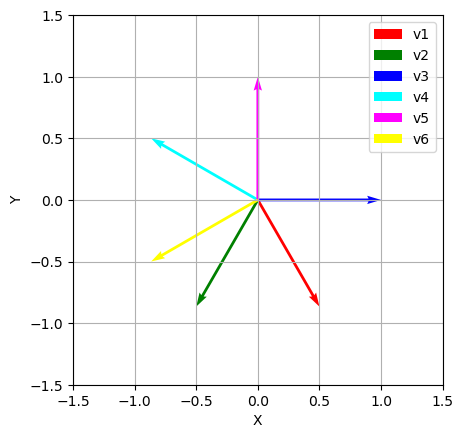

In [53]:
import numpy as np
import matplotlib.pyplot as plt

# 定义三个向量
v1 = np.array([0.5, -0.8660254, 0])
v2 = np.array([-0.5, -0.8660254, 0])
v3 = np.array([1.0000000e+00, 2.0634445e-09, 0.0000000e+00])

v4 = np.array([-0.86602541,  0.5       ,  0.        ])
v5 = np.array([2.08240569e-09, 1.00000000e+00, 0.00000000e+00])
v6 = np.array([-0.8660254, -0.5      ,  0.       ])

# 将向量的 z 分量设为 0，得到它们在 xy 平面的投影
v1_xy = v1[:2]
v2_xy = v2[:2]
v3_xy = v3[:2]
v4_xy = v4[:2]
v5_xy = v5[:2]
v6_xy = v6[:2]
# 创建图形
plt.figure()

# 绘制向量的投影
plt.quiver(0, 0, v1_xy[0], v1_xy[1], angles='xy', scale_units='xy', scale=1, color='r', label='v1')
plt.quiver(0, 0, v2_xy[0], v2_xy[1], angles='xy', scale_units='xy', scale=1, color='g', label='v2')
plt.quiver(0, 0, v3_xy[0], v3_xy[1], angles='xy', scale_units='xy', scale=1, color='b', label='v3')
plt.quiver(0, 0, v4_xy[0], v4_xy[1], angles='xy', scale_units='xy', scale=1, color='cyan', label='v4')
plt.quiver(0, 0, v5_xy[0], v5_xy[1], angles='xy', scale_units='xy', scale=1, color='magenta', label='v5')
plt.quiver(0, 0, v6_xy[0], v6_xy[1], angles='xy', scale_units='xy', scale=1, color='yellow', label='v6')


# 设置坐标轴
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()

# 显示图形
plt.grid()
plt.show()


In [48]:
import numpy as np

# 定义三个向量
# v1 = np.array([0.5, -0.8660254, 0])
# v2 = np.array([-0.5, -0.8660254, 0])
# v3 = np.array([1.0000000e+00, 2.0634445e-09, 0.0000000e+00])
v1 = np.array([-0.86602541,  0.5       ,  0.        ])
v2 = np.array([2.08240569e-09, 1.00000000e+00, 0.00000000e+00])
v3 = np.array([-0.8660254, -0.5      ,  0.       ])

# 计算向量的模
norm_v1 = np.linalg.norm(v1)
norm_v2 = np.linalg.norm(v2)
norm_v3 = np.linalg.norm(v3)

# 计算向量的点积
dot_v1_v2 = np.dot(v1, v2)
dot_v1_v3 = np.dot(v1, v3)
dot_v2_v3 = np.dot(v2, v3)

# 计算夹角（以弧度为单位）
theta_v1_v2 = np.arccos(dot_v1_v2 / (norm_v1 * norm_v2))
theta_v1_v3 = np.arccos(dot_v1_v3 / (norm_v1 * norm_v3))
theta_v2_v3 = np.arccos(dot_v2_v3 / (norm_v2 * norm_v3))

# 将弧度转换为度数
theta_v1_v2_deg = np.degrees(theta_v1_v2)
theta_v1_v3_deg = np.degrees(theta_v1_v3)
theta_v2_v3_deg = np.degrees(theta_v2_v3)

print("v1和v2的夹角:", theta_v1_v2_deg)
print("v1和v3的夹角:", theta_v1_v3_deg)
print("v2和v3的夹角:", theta_v2_v3_deg)


v1和v2的夹角: 60.00000029737578
v1和v3的夹角: 59.99999993035347
v2和v3的夹角: 120.00000022772926
